# CT5135 Assignment-2 
## Using Canny Edge Detector Output as the feature for Classification
### Importing Libraries

In [1]:
import numpy as np
import pandas as pd 
from sklearn import metrics 
from glob import glob 
from tqdm import tqdm

import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import timm
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim 
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import DataLoader

from PIL import Image


### Setting up the configuration for the experiment

In [2]:
class CFG:
    train_batch_size=64
    batch_size=32
    loss_fn=nn.CrossEntropyLoss()
    epochs=10
    stats=False
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ',CFG.device)

Device:  cuda


### Plotting the Edge features for the respective classes 

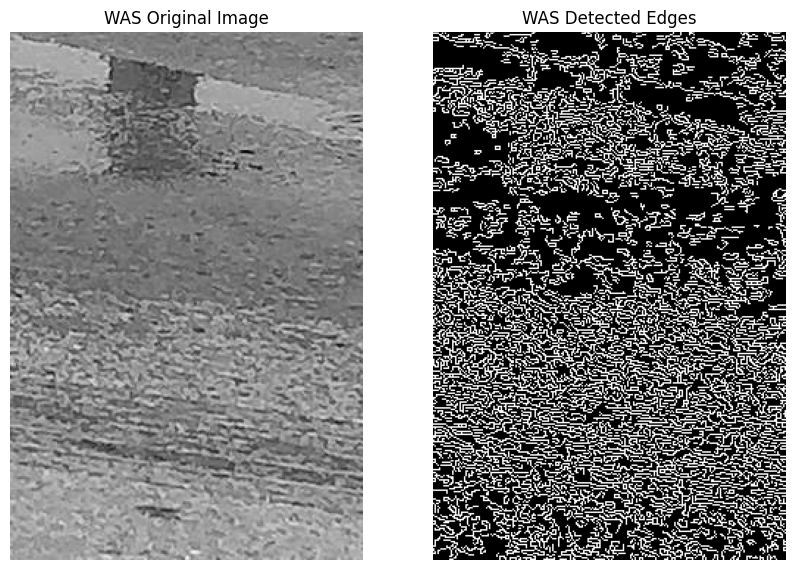

In [3]:
def edge_features(img_path,name):
    image=cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image,50,100)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.title(str(name+' Original Image'))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(edges,cmap='gray')
    plt.title(str(name+' Detected Edges'))
    plt.axis('off')
    plt.show()

edge_features('/kaggle/input/road-surface-dataset/Group_6_water_smooth/train/water_asphalt_smooth/2022012619360610-water-asphalt-smooth.jpg','WAS')



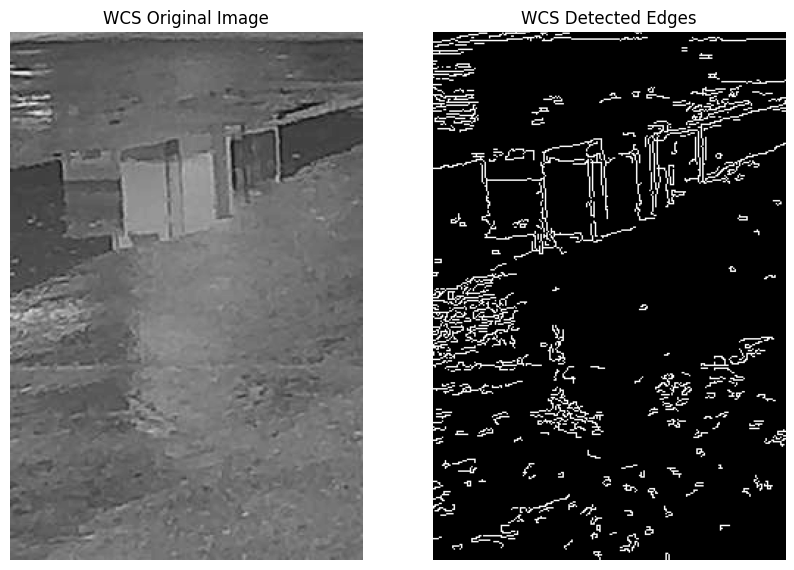

In [4]:
edge_features('/kaggle/input/road-surface-dataset/Group_6_water_smooth/train/water_concrete_smooth/202201262341571-water-concrete-smooth.jpg','WCS')

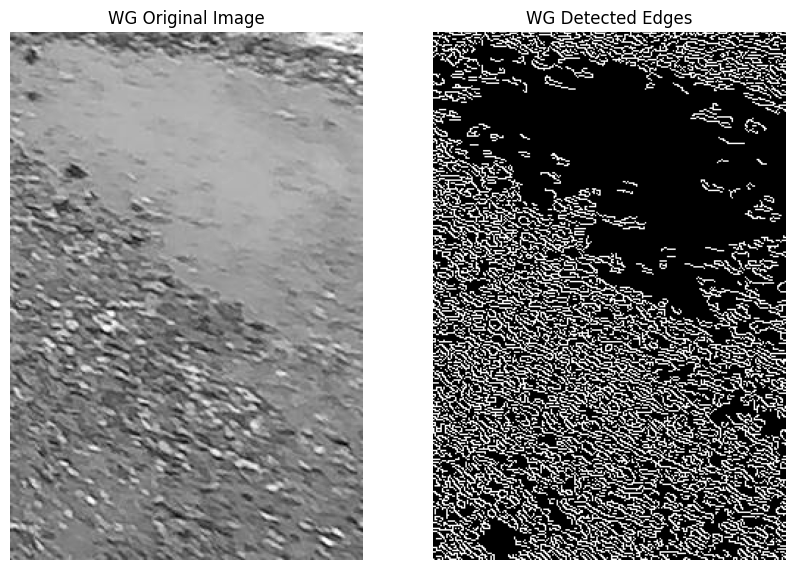

In [5]:
edge_features('/kaggle/input/road-surface-dataset/Group_6_water_smooth/train/water_gravel/202203251238581-water-gravel.jpg','WG')

## Procuring the Subset from the training data

This step is done in order to procure a subset for the training of the neural network. This was done due to computation and space constraints. An alternate equivalent approach is to perform K fold cross validation and choose some of the folds for the training. 

In [6]:
train_data_path='/kaggle/input/road-surface-dataset/Group_6_water_smooth/train'
transform= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda x:cv2.Canny(cv2.cvtColor(x,cv2.COLOR_RGB2BGR),50,100)),
    transforms.ToTensor()
])
#Sampling the training data
train_dataset_full=datasets.ImageFolder(train_data_path,transform=transform)
#Finding the class counts
class_counts=np.bincount(train_dataset_full.targets)
#FIniding the minimum class count present
min_samples_per_class=min(class_counts)
#Finding the number of data points to take from the classes (14500 data points were chosen which has equal class distribution)
num_samples_per_class=min(min_samples_per_class,14500//len(train_dataset_full.classes))
#Finding number of samples to be considered
total_num_samples=num_samples_per_class*len(train_dataset_full.classes)
balanced_indices=[]
for idx in range(len(train_dataset_full.classes)):
    class_indices=np.where(np.array(train_dataset_full.targets)==idx)[0]
    sampled_indices=np.random.choice(class_indices,num_samples_per_class,replace=False)
    balanced_indices.extend(sampled_indices)
#Creating Subset of Data
train_dataset=torch.utils.data.Subset(train_dataset_full, balanced_indices[:total_num_samples])




### Setting the Image transform to be considered 

Here in the Image transform the images are resized to 224x224 size and then Canny Edge detection is applied on the image. This data is then converted to a tensor which can now be passed into the model.

In [7]:
image_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda x:cv2.Canny(cv2.cvtColor(np.array(x),cv2.COLOR_RGB2BGR),50,100)),
    transforms.ToTensor()
])

### Creating the Torch Datasets

Torch datasets are necessary in order to pass the data into the model. The data is maintained here depnding on the batch size specified. It is an efficient in both computation and memory.

In [8]:
val_data_path='/kaggle/input/road-surface-dataset/Group_6_water_smooth/valid'
test_data_path='/kaggle/input/road-surface-dataset/Group_6_water_smooth/test'
val_dataset=datasets.ImageFolder(val_data_path,transform=image_transform)
test_dataset=datasets.ImageFolder(test_data_path,transform=image_transform)

In [9]:
train_loader=DataLoader(train_dataset,batch_size=CFG.train_batch_size,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=CFG.batch_size,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=CFG.batch_size,shuffle=False)

### Creating the Model 

A custom CNN model with residual connections is created with the torch.nn module. Residual connections in CNN were not implemented for this task, and the data of edges were not considered for the classification task. Here the Residual block and the CNN block are created separately and this helps to easily modify the architecture depending on the complexity. The residual block checks internally if the dimensions match to perform the addition operation else a separate network is used to procure the data that can be used by the residual network.

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1):
        super(ResidualBlock,self).__init__()
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(out_channels)
        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2=nn.BatchNorm2d(out_channels)
        self.relu=nn.ReLU(inplace=True)
        self.stride=stride
        if stride!=1 or in_channels!=out_channels:
            self.residual=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.residual=nn.Identity()

    def forward(self,x):
        identity=self.residual(x)
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        out=self.conv2(out)
        out=self.bn2(out)
        out+=identity
        out=self.relu(out)
        return out

class ConvResNet(nn.Module):
    def __init__(self,in_channels,num_classes):
        super(ConvResNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels,64,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU(inplace=True)
        self.residual1=ResidualBlock(64,64)
        self.conv2=nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1,bias=False)
        self.bn2=nn.BatchNorm2d(128)
        self.residual2=ResidualBlock(128,128)
        self.conv3=nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1,bias=False)
        self.bn3=nn.BatchNorm2d(256)
        self.residual3=ResidualBlock(256,256)
        self.avg_pool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Linear(256,num_classes)

    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.residual1(x)
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu(x)
        x=self.residual2(x)
        x=self.conv3(x)
        x=self.bn3(x)
        x=self.relu(x)
        x=self.residual3(x)
        x=self.avg_pool(x)
        x=torch.flatten(x, 1)
        x=self.fc(x)
        return x


### Training Loop

Here the training loop trains on the training data, and validates the model on the validation dataset. It uses the Rectified Adam which is a variant of the Adam optimizer used to rectify the variance in the learning rate changes. The loss function used is the Cross Entropy Loss which is effective in classification tasks. GPU is used from Kaggle in order to train the model and save the weights. The learning curves and the accuracy curves are plotted to help judge the performance.

100%|██████████| 227/227 [07:29<00:00,  1.98s/it]


Epoch 1/10, Train Loss:0.8756300867676808, Train accuracy:0.5888681978067453
Validation Loss: 2.184204066626546, Validation Accuracy: 0.5235772357723577


100%|██████████| 227/227 [05:19<00:00,  1.41s/it]


Epoch 2/10, Train Loss:0.9997362311490363, Train accuracy:0.5257975116457339
Validation Loss: 0.9135819257759467, Validation Accuracy: 0.5638211382113821


100%|██████████| 227/227 [05:18<00:00,  1.40s/it]


Epoch 3/10, Train Loss:0.9184135657169464, Train accuracy:0.5610590247066455
Validation Loss: 0.8990692286956601, Validation Accuracy: 0.5764227642276423


100%|██████████| 227/227 [05:21<00:00,  1.42s/it]


Epoch 4/10, Train Loss:0.9000525619253733, Train accuracy:0.575564596969161
Validation Loss: 0.9001605049381411, Validation Accuracy: 0.5768292682926829


100%|██████████| 227/227 [05:20<00:00,  1.41s/it]


Epoch 5/10, Train Loss:0.8889860872671813, Train accuracy:0.579102541423433
Validation Loss: 0.8752716460848242, Validation Accuracy: 0.5841463414634146


100%|██████████| 227/227 [05:22<00:00,  1.42s/it]


Epoch 6/10, Train Loss:0.8755890645975244, Train accuracy:0.5896574090453447
Validation Loss: 0.8546692911202346, Validation Accuracy: 0.6077235772357723


100%|██████████| 227/227 [05:23<00:00,  1.42s/it]


Epoch 7/10, Train Loss:0.8583221068603597, Train accuracy:0.6001533109263518
Validation Loss: 0.8396865333968062, Validation Accuracy: 0.5995934959349594


100%|██████████| 227/227 [05:22<00:00,  1.42s/it]


Epoch 8/10, Train Loss:0.8138044486745356, Train accuracy:0.6242113332154019
Validation Loss: 0.7459962354927528, Validation Accuracy: 0.6642276422764227


100%|██████████| 227/227 [05:23<00:00,  1.42s/it]


Epoch 9/10, Train Loss:0.768852695102272, Train accuracy:0.6559349018220414
Validation Loss: 0.7317525190066516, Validation Accuracy: 0.6796747967479675


100%|██████████| 227/227 [05:21<00:00,  1.42s/it]


Epoch 10/10, Train Loss:0.7349059845638387, Train accuracy:0.6744501444660652
Validation Loss: 0.7620672797769066, Validation Accuracy: 0.6516260162601626


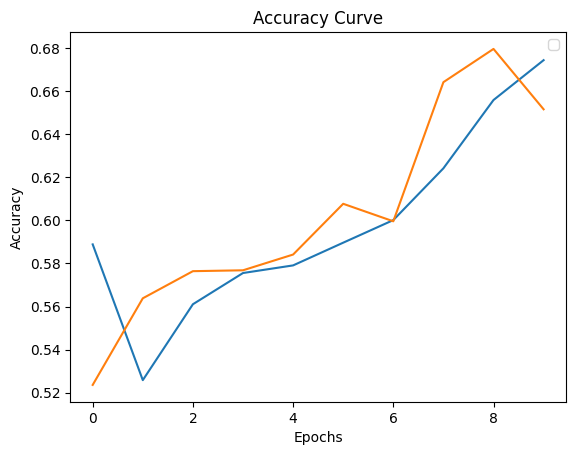

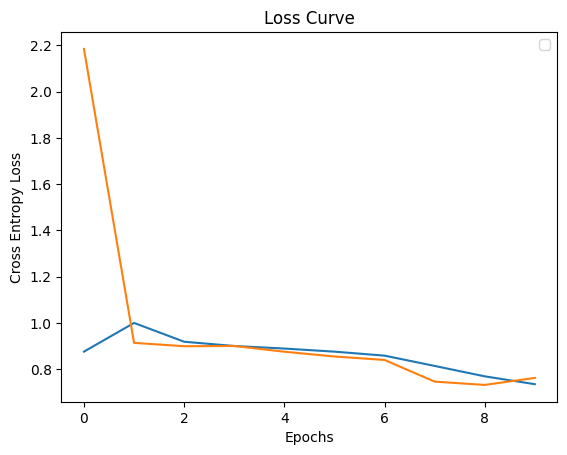

In [11]:
device=CFG.device
model=ConvResNet(1,3).to(device)
optimizer=optim.RAdam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss().to(device)
def train_fn(model,train_loader,criterion,optimizer,num_epochs):
    train_losses=[]
    val_losses=[]
    train_accs=[]
    val_accs=[]
    train_loss=0.0
    correct=0
    total=0
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images,labels in tqdm(train_loader):
            images,labels=images.to(device),labels.to(device) 
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()*images.size(0)
            _,predicted=torch.max(outputs,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
        epoch_loss=running_loss/len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_acc=correct/total
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss:{epoch_loss}, Train accuracy:{train_acc}")
        model.eval()
        val_loss=0.0
        correct=0
        total=0
        with torch.no_grad():
            for images,labels in val_loader:
                images,labels=images.to(device),labels.to(device) 
                outputs=model(images)
                loss=criterion(outputs,labels)
                val_loss+=loss.item()*images.size(0)
                _,predicted=torch.max(outputs,1)
                total+=labels.size(0)
                correct+=(predicted==labels).sum().item()
        val_loss/=len(val_loader.dataset)
        val_losses.append(val_loss)
        val_acc=correct/total
        val_accs.append(val_acc)
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")
    plt.figure()
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.figure()
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Loss Curve')
    plt.legend()
train_fn(model,train_loader,criterion,optimizer,CFG.epochs)

### Testing Loop

The model predicts the test data and the performace is shown as the overall accuracy and F1 score achieved. Accuracy cannot be openly taken as the data label distribution is imbalanced. 

In [12]:
model.eval()
test_loss=0.0
correct=0
total=0
predictions=[]
targets_list=[]
with torch.no_grad():
    for images,labels in tqdm(test_loader):
        images, labels=images.to(device), labels.to(device) 
        outputs=model(images)
        loss=criterion(outputs, labels)
        test_loss+=loss.item()*images.size(0)
        _,predicted=torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        targets_list.extend(labels.cpu().numpy())
        total+=labels.size(0)
        correct+=(predicted == labels).sum().item()
test_loss/=len(test_loader.dataset)
test_acc=correct/total
f1=metrics.f1_score(targets_list, predictions, average='macro')
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}, F1 Score: {f1}")



100%|██████████| 94/94 [00:51<00:00,  1.84it/s]

Test Loss: 0.5991427860065399, Test Accuracy: 0.7692307692307693, F1 Score: 0.532684775809469


### Confusion Matrix
Confusion Matrix can help us further analyse the trend of prediction in the test dataset. From the result we can see class 0 (Water Asphalt Smooth) performs bad when compared to other classes. 

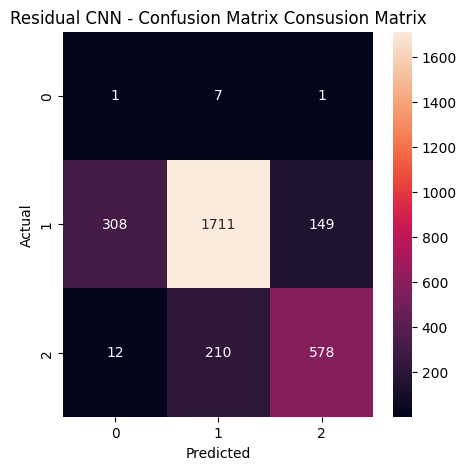

In [13]:
def conf_matrix_plotter(ytest,ypred,figname):
    confusion=metrics.confusion_matrix(ytest,ypred)
    plt.figure(figsize=(5,5))
    sns.heatmap(confusion,annot=True,fmt='d')
    plt.title(f"{figname}")
    plt.xlabel('Predicted')
    plt.ylabel("Actual")
    plt.show()
conf_matrix_plotter(targets_list,predictions,'Residual CNN - Confusion Matrix')

### Saving the model 

The models state dictionary is saved which can be loaded at any point in order to be used for any web interface.

In [14]:
torch.save(model.state_dict(),'residual-model-final-canny.pth')